In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import  Dropout, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator,DirectoryIterator
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.applications.vgg16 import VGG16
import pandas as pd
from tensorflow.keras.models import load_model
from tensorflow.keras.applications import VGG19
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from keras.callbacks import ModelCheckpoint, EarlyStopping
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import os

In [303]:
train_data_dir ="moheddine/train224"
validation_data_dir = "moheddine/test224"


In [3]:
def CompilerModel(model,fonctionloss,fonctionOptimizer):
    model.compile(loss=fonctionloss,
    optimizer=fonctionOptimizer, metrics=["accuracy"])

In [4]:
def SaveBestModel(NomdeSauvegarde):
    return ModelCheckpoint(NomdeSauvegarde, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
def early_stopping(patience):
    return EarlyStopping(monitor='val_accuracy', patience=patience, mode='max', verbose=1)


***FUNCTION WITH DATA AUGMENTATION***







In [5]:
def dataAugmentation():
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest')

    validation_datagen = ImageDataGenerator(rescale=1./255)
    return train_datagen,validation_datagen

In [7]:
def Chargement_des_donnees_avec_flow_from_directory (batch_size,train_datagen,validation_datagen):
    train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(64, 64),
        batch_size=batch_size,
        class_mode='categorical')

    validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(64, 64),
        batch_size=batch_size,
        class_mode='categorical')
    return train_generator,validation_generator

In [11]:
def Chargement_des_donnees_avec_flow_from_directory1 (batch_size,train_datagen,validation_datagen):
    train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='categorical')

    validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='categorical')
    return train_generator,validation_generator

**FUNCTION WITHOUT DATA AUGMENTATION**

In [20]:
def dataGenWithoutDataAugmentation(batch_size):
    train_generator = DirectoryIterator(
        train_data_dir,
        target_size=(64, 64),
        image_data_generator=None,  # No data augmentation
        batch_size=batch_size,
        class_mode='categorical', 
    )


    validation_generator = DirectoryIterator(
        validation_data_dir,
        target_size=(64, 64),
        image_data_generator=None,  # No data augmentation
        batch_size=batch_size,
        class_mode='categorical',  
    )


    return train_generator, validation_generator


**TRAIN DU MODELE**

In [8]:
def TrainModel(model,nbrepochs,train_generator,validation_generator,NomdeSauvegarde,patience):
    checkpoint=SaveBestModel(NomdeSauvegarde)
    earlystopping=early_stopping(patience)

    return model.fit_generator(
    train_generator,
    steps_per_epoch = len(train_generator),
    epochs = nbrepochs,
    validation_data = validation_generator,
    validation_steps = len(validation_generator),
    callbacks = [checkpoint, earlystopping])

**EXECUTION DU MODELE**

In [4]:
def Main_Model( model,batch_size,loss,optimizer,NomBestModel,patience,nbrepochs,status):
    CompilerModel(model,loss,optimizer)
    if(status=="withdataAugementation"):
      train_datagen,validation_datagen=dataAugmentation()
      train_generator,validation_generator=Chargement_des_donnees_avec_flow_from_directory(batch_size,train_datagen,validation_datagen)

    else:
      train_generator,validation_generator=dataGenWithoutDataAugmentation(batch_size)



    history=TrainModel(model,nbrepochs,train_generator,validation_generator,NomBestModel,patience)
    return history,validation_generator

**DEFINITION DES PARAMETRES**

In [15]:
parmas={
      'batch_size':100,
      'loss':binary_crossentropy,
      'optimizer':Adam(learning_rate=0.0001),
      'patience':10,
      'nbrepochs':30
}

**EVALUATION DU MODELE**

In [9]:
def evaluerModel(nomBestModel,validation_gen):
  model = load_model(nomBestModel)
  loss, accuracy = model.evaluate_generator(validation_gen, verbose=1)
  results_dict = {'loss': loss, 'accuracy': accuracy}
  return results_dict

**PART 4 : CREATION DES MODELE A COMPARER**

**4_1)CREATION MODEL CNN FROM SCRATCH**

In [15]:
def Creation_modelCNNFromScratch():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape=(64, 64,3), activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(32, (3, 3), activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation="relu"))
    model.add(Dense(64, activation="relu"))
    model.add(Dense(2, activation="softmax"))
    return model

**4_2)CREATION MODELE VGG 16**

**4_2_1) AVEC FREEZE ALL LAYERS**

In [16]:
def Creation_modelVGG16avecfreeze_ALL():
    model=VGG16(weights="imagenet",include_top=False,input_shape=(64,64,3))
    for layer in model.layers:
        layer.trainable = False
    x=model.output
    x=Flatten()(x)
    x=Dense(64, activation='relu')(x)
    x=Dropout(0.5)(x)
    x=Dense(64, activation='relu')(x)
    prediction=Dense(2, activation='softmax')(x)
    model=Model(inputs=model.input,outputs=prediction)
    return model

**4_2_2)AVEC  FREEZE 5 PREMIERS**

In [17]:
def Creation_modelVGG16avecfreeze_cinq():
    model=VGG16(weights="imagenet",include_top=False,input_shape=(64,64,3))
    for layer in model.layers[:5]:
        layer.trainable = False
    x=model.output
    x=Flatten()(x)
    x=Dense(64, activation='relu')(x)
    x=Dropout(0.5)(x)
    x=Dense(64, activation='relu')(x)
    prediction=Dense(2, activation='softmax')(x)
    model=Model(inputs=model.input,outputs=prediction)
    return model

**4_2_3)WITHOUT FREEZE**

In [11]:
def Creation_modelVGG16_Withoutfreeze():
    model=VGG16(weights="imagenet",include_top=False,input_shape=(64,64,3))
    for layer in model.layers:
        layer.trainable = True
    x=model.output
    x=Flatten()(x)
    x=Dense(64, activation='relu')(x)
    x=Dropout(0.5)(x)
    x=Dense(64, activation='relu')(x)
    prediction=Dense(2, activation='softmax')(x)
    model=Model(inputs=model.input,outputs=prediction)
    return model

**4_3)CREATION MODELE VGG19**

**4_3_1)without including Fully connected Layer**

In [11]:
def Creation_modelVGG19False():
    model=VGG19(weights="imagenet",include_top=False,input_shape=(64,64,3))
    for layer in model.layers[:5]:
        layer.trainable = False
    x=model.output
    x=Flatten()(x)
    x=Dense(64, activation='relu')(x)
    x=Dropout(0.5)(x)
    x=Dense(64, activation='relu')(x)
    prediction=Dense(2, activation='softmax')(x)
    model=Model(inputs=model.input,outputs=prediction)
    return model

**4_3_2)with including Fully connected Layer**

In [1]:
from numpy import reshape


def Creation_modelVGG19True():
    model=VGG19(weights="imagenet",include_top=True,input_shape=(224,224,3))
    for layer in model.layers[:5]:
        layer.trainable = False
    x = model.layers[-2].output
    x=Dense(64, activation='relu')(x)
    prediction=Dense(2, activation='softmax')(x)
    model=Model(inputs=model.input,outputs=prediction)
    return model

**PART 5 : ENTRAINEMENT DES MODELES**

**PART 5_1 : COMPARAISON ENTRE CNN FROM  SCRATCH WITH DATA AUGEMENTAION ET WITHOUT DATA AUGMENTATION**






***5_1_1)ENTRAINEMENT DU MOEDELE CNN FROM SCRATCH WITH DATA AUGEMENTATION***

In [21]:
modelCNNFromScratchWithDataAugmentaion=Creation_modelCNNFromScratch()
historyModelCNNFromScratchWithDataAugmentaion,validation_generatorCNNWithDataAugmentaion=Main_Model(modelCNNFromScratchWithDataAugmentaion,
                                      parmas['batch_size'],
                                      parmas['loss'],
                                      parmas['optimizer'],
                                      "BestModelCNN_FromScratchWITHDataAugmentation.h5",
                                      parmas['patience'],
                                      parmas['nbrepochs'],
                                      "withdataAugementation"
                                      )

Found 5944 images belonging to 2 classes.
Found 3060 images belonging to 2 classes.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_23000\464600863.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  return model.fit_generator(


Epoch 1/30
60/60 [==============================] - ETA: 0s - loss: 0.5629 - accuracy: 0.7544
Epoch 1: val_accuracy improved from -inf to 0.86144, saving model to BestModelCNN_FromScratchWITHDataAugmentation.h5
60/60 [==============================] - 17s 276ms/step - loss: 0.5629 - accuracy: 0.7544 - val_loss: 0.3915 - val_accuracy: 0.8614
Epoch 2/30
60/60 [==============================] - ETA: 0s - loss: 0.3842 - accuracy: 0.8488
Epoch 2: val_accuracy improved from 0.86144 to 0.90359, saving model to BestModelCNN_FromScratchWITHDataAugmentation.h5
60/60 [==============================] - 17s 292ms/step - loss: 0.3842 - accuracy: 0.8488 - val_loss: 0.2964 - val_accuracy: 0.9036
Epoch 3/30
60/60 [==============================] - ETA: 0s - loss: 0.3234 - accuracy: 0.8816
Epoch 3: val_accuracy improved from 0.90359 to 0.90915, saving model to BestModelCNN_FromScratchWITHDataAugmentation.h5
60/60 [==============================] - 19s 312ms/step - loss: 0.3234 - accuracy: 0.8816 - val_l

***5_1_2)ENTRAINEMENT DU MOEDELE CNN FROM SCRATCH WITHOUT DATA AUGEMENTATION***

In [22]:
modelCNNFromScratchWithoutDataAugmentaion=Creation_modelCNNFromScratch()
historyModelCNNFromScratchWithoutDataAugmentaion,validation_generatorCNNWithoutDataAugmentaion=Main_Model(modelCNNFromScratchWithoutDataAugmentaion,
                                      parmas['batch_size'],
                                      parmas['loss'],
                                      parmas['optimizer'],
                                      "BestModelCNN_FromScratchWITHOUTDataAugmentaion.h5",
                                      parmas['patience'],
                                      parmas['nbrepochs'],
                                      "WITHOUTdataAugementation"
                                      )

Found 5944 images belonging to 2 classes.
Found 3060 images belonging to 2 classes.
Epoch 1/30


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_23000\464600863.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  return model.fit_generator(


60/60 [==============================] - ETA: 0s - loss: 2.8459 - accuracy: 0.7986
Epoch 1: val_accuracy improved from -inf to 0.90327, saving model to BestModelCNN_FromScratchWITHOUTDataAugmentaion.h5
60/60 [==============================] - 10s 158ms/step - loss: 2.8459 - accuracy: 0.7986 - val_loss: 0.3090 - val_accuracy: 0.9033
Epoch 2/30
60/60 [==============================] - ETA: 0s - loss: 0.2920 - accuracy: 0.9024
Epoch 2: val_accuracy improved from 0.90327 to 0.92386, saving model to BestModelCNN_FromScratchWITHOUTDataAugmentaion.h5
60/60 [==============================] - 10s 173ms/step - loss: 0.2920 - accuracy: 0.9024 - val_loss: 0.2425 - val_accuracy: 0.9239
Epoch 3/30
60/60 [==============================] - ETA: 0s - loss: 0.2354 - accuracy: 0.9228
Epoch 3: val_accuracy did not improve from 0.92386
60/60 [==============================] - 11s 186ms/step - loss: 0.2354 - accuracy: 0.9228 - val_loss: 0.2495 - val_accuracy: 0.9157
Epoch 4/30
60/60 [=======================

**5_1_3) EVALUTION DU DEUX MODELE**

In [52]:
resultat_ModelCNNWithDataAugmentaion=evaluerModel( "BestModelCNN_FromScratchWITHDataAugmentation.h5",validation_generatorCNNWithoutDataAugmentaion)
resultat_ModelCNNWithoutDataAugmentaion=evaluerModel( "BestModelCNN_FromScratchWITHOUTDataAugmentaion.h5",validation_generatorCNNWithoutDataAugmentaion)

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_12924\4089831305.py:3: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  loss, accuracy = model.evaluate_generator(validation_gen, verbose=1)


31/31 [==============================] - 3s 90ms/step - loss: 0.2764 - accuracy: 0.9412


***5_1_4)COMPARER***

In [95]:
print("RESULAT DU MODELE CNN FROM SCRATCH  AVEC DATA AUGMENTATION :\n")
df_true = pd.DataFrame(resultat_ModelCNNWithDataAugmentaion, index=[0])
print(df_true)
print("\n\nRESULAT DU MODELE CNN FROM SCRATCH  WITHOUT DATA AUGMENTATION :\n")
df_false = pd.DataFrame(resultat_ModelCNNWithoutDataAugmentaion, index=[0])
print(df_false)



RESULAT DU MODELE CNN FROM SCRATCH  AVEC DATA AUGMENTATION :

       loss  accuracy
0  0.151866  0.949346


RESULAT DU MODELE CNN FROM SCRATCH  WITHOUT DATA AUGMENTATION :

       loss  accuracy
0  0.276368  0.941176


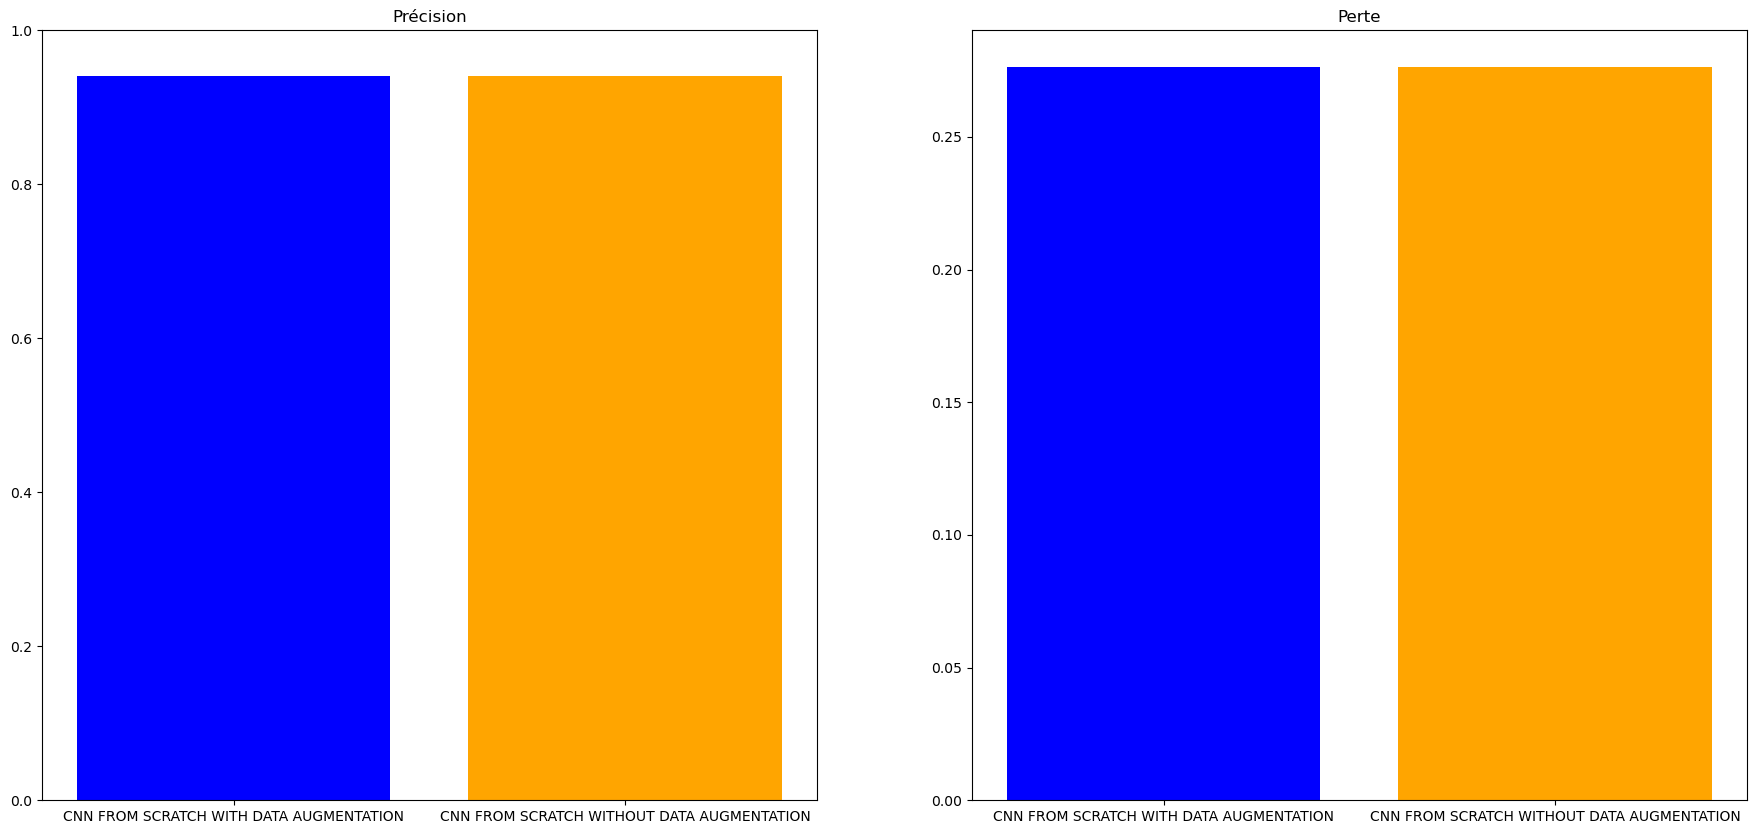

In [90]:
import matplotlib.pyplot as plt

# Récupérer les résultats
resultat_ModelCNNWithDataAugmentaion = {"loss": resultat_ModelCNNWithDataAugmentaion["loss"], "accuracy": resultat_ModelCNNWithDataAugmentaion["accuracy"]}
resultat_ModelCNNWithoutDataAugmentaion={"loss": resultat_ModelCNNWithoutDataAugmentaion["loss"], "accuracy": resultat_ModelCNNWithoutDataAugmentaion["accuracy"]}

# Créer une figure avec deux sous-graphiques
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(22, 10))

# Tracer l'histogramme pour la précision
ax1.bar(["CNN FROM SCRATCH WITH DATA AUGMENTATION", "CNN FROM SCRATCH WITHOUT DATA AUGMENTATION"],
        [resultat_ModelCNNWithoutDataAugmentaion['accuracy'],
         resultat_ModelCNNWithoutDataAugmentaion['accuracy']],
        color=['blue', 'orange', 'green'])
ax1.set_title('Précision')
ax1.set_ylim([0, 1])

# Tracer l'histogramme pour la perte
ax2.bar(["CNN FROM SCRATCH WITH DATA AUGMENTATION", "CNN FROM SCRATCH WITHOUT DATA AUGMENTATION"],
        [resultat_ModelCNNWithoutDataAugmentaion['loss'],
         resultat_ModelCNNWithoutDataAugmentaion['loss']],
        color=['blue', 'orange', 'green'])
ax2.set_title('Perte')

# Afficher la figure
plt.show()

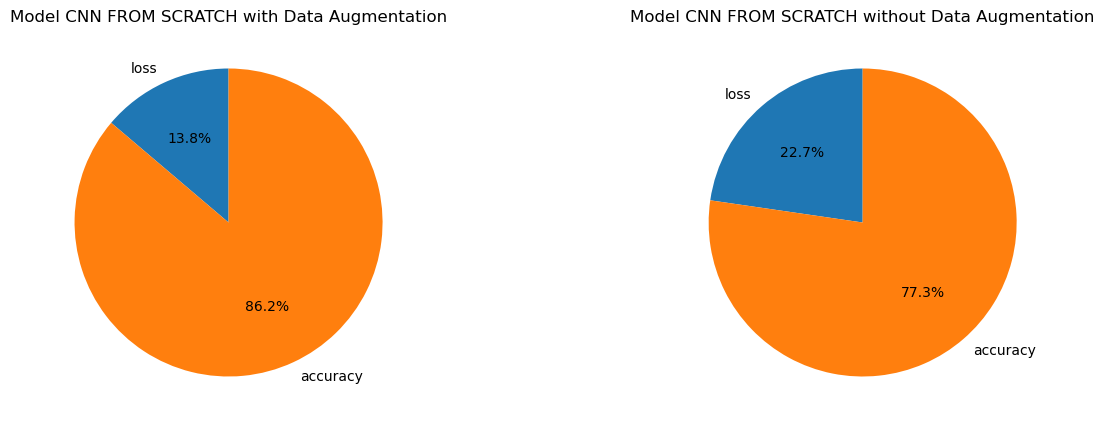

In [254]:
import matplotlib.pyplot as plt
resultat_ModelCNNWithDataAugmentaion = {"loss": resultat_ModelCNNWithDataAugmentaion["loss"], "accuracy": resultat_ModelCNNWithDataAugmentaion["accuracy"]}
resultat_ModelCNNWithoutDataAugmentaion={"loss": resultat_ModelCNNWithoutDataAugmentaion["loss"], "accuracy": resultat_ModelCNNWithoutDataAugmentaion["accuracy"]}
labels = list(resultat_ModelCNNWithDataAugmentaion.keys())
values_with_data_augmentation = list(resultat_ModelCNNWithDataAugmentaion.values())
values_without_data_augmentation = list(resultat_ModelCNNWithoutDataAugmentaion.values())

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

accuracy_with=axs[0].pie(values_with_data_augmentation, labels=labels, autopct='%1.1f%%', startangle=90)
t__with=axs[0].set_title('Model CNN FROM SCRATCH with Data Augmentation')

accuracy_without=axs[1].pie(values_without_data_augmentation, labels=labels, autopct='%1.1f%%', startangle=90)
t__without=axs[1].set_title('Model CNN FROM SCRATCH without Data Augmentation')

plt.show()

**COMMENT**

In [255]:
text_representation = str(accuracy_with[-1][-1])
t__with=str(t__with).split("'")[-2]

val_accuracy_with = text_representation.split("'")[-2]
print("Accuracy de ",t__with," est ",val_accuracy_with)

text_representation = str(accuracy_without[-1][-1])
val_accuracy_without = text_representation.split("'")[-2]
t__without=str(t__without).split("'")[-2]
print("Accuracy de ",t__without," est ", val_accuracy_without)


print("\n\nBest Model : ")
if(val_accuracy_with>val_accuracy_without):
    best_model_CNN_FROM_SCRATCH={t__with:val_accuracy_with,"model":resultat_ModelCNNWithDataAugmentaion}
    print("Accuracy de best model est le model",t__with," est ",val_accuracy_with)
else:
    best_model_CNN_FROM_SCRATCH={t__without:val_accuracy_without,"model":resultat_ModelCNNWithoutDataAugmentaion}
    print("Accuracy de best model est le model ",t__without," est ",val_accuracy_without)


Accuracy de  Model CNN FROM SCRATCH with Data Augmentation  est  86.2%
Accuracy de  Model CNN FROM SCRATCH without Data Augmentation  est  77.3%


Best Model : 
Accuracy de best model est le model Model CNN FROM SCRATCH with Data Augmentation  est  86.2%


**PART 5_2 :*COMPARAISON* ENTRE MODELE VGG 16  AVEC FREEZE / AVEC FREEZE _cinq /WITHOUT FREEZE /**

 **5_2_1)ENTRAINEMENT DU MODELE  VGG 16 AVEC FREEZE ALL**


In [26]:
modelVGG16avecfreeze_ALL=Creation_modelVGG16avecfreeze_ALL()
historymodelVGG16avecfreeze_ALL,validation_generatormodelVGG16avecfreeze_ALL=Main_Model(modelVGG16avecfreeze_ALL,
                                      parmas['batch_size'],
                                      parmas['loss'],
                                      parmas['optimizer'],
                                      "BestModel_Vgg16Freeze_all.h5",
                                      parmas['patience'],
                                      parmas['nbrepochs'],
                                      "withdataAugementation"
                                      )

Found 5944 images belonging to 2 classes.
Found 3060 images belonging to 2 classes.
Epoch 1/30


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_23000\464600863.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  return model.fit_generator(


60/60 [==============================] - ETA: 0s - loss: 0.4570 - accuracy: 0.7899
Epoch 1: val_accuracy improved from -inf to 0.87288, saving model to BestModel_Vgg16Freeze_all.h5
60/60 [==============================] - 66s 1s/step - loss: 0.4570 - accuracy: 0.7899 - val_loss: 0.2999 - val_accuracy: 0.8729
Epoch 2/30
60/60 [==============================] - ETA: 0s - loss: 0.3081 - accuracy: 0.8772
Epoch 2: val_accuracy improved from 0.87288 to 0.89314, saving model to BestModel_Vgg16Freeze_all.h5
60/60 [==============================] - 70s 1s/step - loss: 0.3081 - accuracy: 0.8772 - val_loss: 0.2604 - val_accuracy: 0.8931
Epoch 3/30
60/60 [==============================] - ETA: 0s - loss: 0.2767 - accuracy: 0.8912
Epoch 3: val_accuracy improved from 0.89314 to 0.91503, saving model to BestModel_Vgg16Freeze_all.h5
60/60 [==============================] - 70s 1s/step - loss: 0.2767 - accuracy: 0.8912 - val_loss: 0.2246 - val_accuracy: 0.9150
Epoch 4/30
60/60 [========================

**5_2_2)ENTRAINEMENT DU MODELE  VGG 16 AVEC FREEZE 5**

In [27]:
modelVGG16avecfreeze_cinq=Creation_modelVGG16avecfreeze_cinq()
historymodelVGG16avecfreeze_cinq,validation_generatormodelVGG16avecfreeze_cinq=Main_Model(modelVGG16avecfreeze_cinq,
                                      parmas['batch_size'],
                                      parmas['loss'],
                                      parmas['optimizer'],
                                      "BestModel_Vgg16Freeze_cinq.h5",
                                      parmas['patience'],
                                      parmas['nbrepochs'],
                                      "withdataAugementation"
                                      )

Found 5944 images belonging to 2 classes.
Found 3060 images belonging to 2 classes.
Epoch 1/30


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_23000\464600863.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  return model.fit_generator(


60/60 [==============================] - ETA: 0s - loss: 0.6900 - accuracy: 0.5395
Epoch 1: val_accuracy improved from -inf to 0.84150, saving model to BestModel_Vgg16Freeze_cinq.h5
60/60 [==============================] - 136s 2s/step - loss: 0.6900 - accuracy: 0.5395 - val_loss: 0.5019 - val_accuracy: 0.8415
Epoch 2/30
60/60 [==============================] - ETA: 0s - loss: 0.3516 - accuracy: 0.8627
Epoch 2: val_accuracy improved from 0.84150 to 0.94150, saving model to BestModel_Vgg16Freeze_cinq.h5
60/60 [==============================] - 131s 2s/step - loss: 0.3516 - accuracy: 0.8627 - val_loss: 0.1791 - val_accuracy: 0.9415
Epoch 3/30
60/60 [==============================] - ETA: 0s - loss: 0.2004 - accuracy: 0.9337
Epoch 3: val_accuracy improved from 0.94150 to 0.95261, saving model to BestModel_Vgg16Freeze_cinq.h5
60/60 [==============================] - 136s 2s/step - loss: 0.2004 - accuracy: 0.9337 - val_loss: 0.1438 - val_accuracy: 0.9526
Epoch 4/30
60/60 [==================

**5_2_3)ENTRAINEMENT DU MODELE  VGG 16 WITHOUT FREEZE**


In [14]:
model_VGG16_Withoutfreeze=Creation_modelVGG16_Withoutfreeze()
historymodel_VGG16_Withoutfreeze,validation_generatormodel_VGG16_Withoutfreeze=Main_Model(model_VGG16_Withoutfreeze,
                                      parmas['batch_size'],
                                        parmas['loss'],
                                      parmas['optimizer'],
                                      "BestModel_Vgg16_WithoutFreeze.h5",
                                      parmas['patience'],
                                      parmas['nbrepochs'],
                                      "withdataAugementation"
                                      )

Found 5944 images belonging to 2 classes.
Found 3060 images belonging to 2 classes.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_10100\464600863.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  return model.fit_generator(


Epoch 1/30
60/60 [==============================] - ETA: 0s - loss: 0.3985 - accuracy: 0.8343
Epoch 1: val_accuracy improved from -inf to 0.95752, saving model to BestModel_Vgg16_WithoutFreeze.h5
60/60 [==============================] - 166s 3s/step - loss: 0.3985 - accuracy: 0.8343 - val_loss: 0.1329 - val_accuracy: 0.9575
Epoch 2/30
60/60 [==============================] - ETA: 0s - loss: 0.1650 - accuracy: 0.9542
Epoch 2: val_accuracy improved from 0.95752 to 0.96601, saving model to BestModel_Vgg16_WithoutFreeze.h5
60/60 [==============================] - 167s 3s/step - loss: 0.1650 - accuracy: 0.9542 - val_loss: 0.1127 - val_accuracy: 0.9660
Epoch 3/30
60/60 [==============================] - ETA: 0s - loss: 0.1250 - accuracy: 0.9652
Epoch 3: val_accuracy improved from 0.96601 to 0.96993, saving model to BestModel_Vgg16_WithoutFreeze.h5
60/60 [==============================] - 173s 3s/step - loss: 0.1250 - accuracy: 0.9652 - val_loss: 0.0973 - val_accuracy: 0.9699
Epoch 4/30
60/60

**5_2_3) EVALUTION MODELES**

In [17]:
resultat_modelVGG16avecfreeze_ALL=evaluerModel( "BestModel_Vgg16Freeze_all.h5",validation_generatorCNNWithoutDataAugmentaion)
resultat_modelVGG16avecfreeze_cinq=evaluerModel( "BestModel_Vgg16Freeze_cinq.h5",validation_generatorCNNWithoutDataAugmentaion)
resultat_modelVGG16_Withoutfreeze=evaluerModel( "BestModel_Vgg16_WithoutFreeze.h5",validation_generatorCNNWithoutDataAugmentaion)



C:\Users\Lenovo\AppData\Local\Temp\ipykernel_12924\4089831305.py:3: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  loss, accuracy = model.evaluate_generator(validation_gen, verbose=1)


31/31 [==============================] - 24s 769ms/step - loss: 0.1033 - accuracy: 0.9778


***5_2_4)COMPARER***

In [59]:
print("\nRESULTAT DU MODELE VGG 16 AVEC FREEZE ALL LAYERS")
print(resultat_modelVGG16avecfreeze_ALL)
print("\nRESULTAT DU MODELE VGG 16 AVEC FREEZE 5 PREMIERS COUCHE CONVS")
print(resultat_modelVGG16avecfreeze_cinq)
print("\nRESULTAT DU MODELE VGG 16 WITHOUT FREEZE ")
print(resultat_modelVGG16_Withoutfreeze)




RESULTAT DU MODELE VGG 16 AVEC FREEZE ALL LAYERS
{'loss': 0.17376749217510223, 'accuracy': 0.9398692846298218}

RESULTAT DU MODELE VGG 16 AVEC FREEZE 5 PREMIERS COUCHE CONVS
{'loss': 0.09702136367559433, 'accuracy': 0.9715686440467834}

RESULTAT DU MODELE VGG 16 WITHOUT FREEZE 
{'loss': 0.10334168374538422, 'accuracy': 0.9777777791023254}


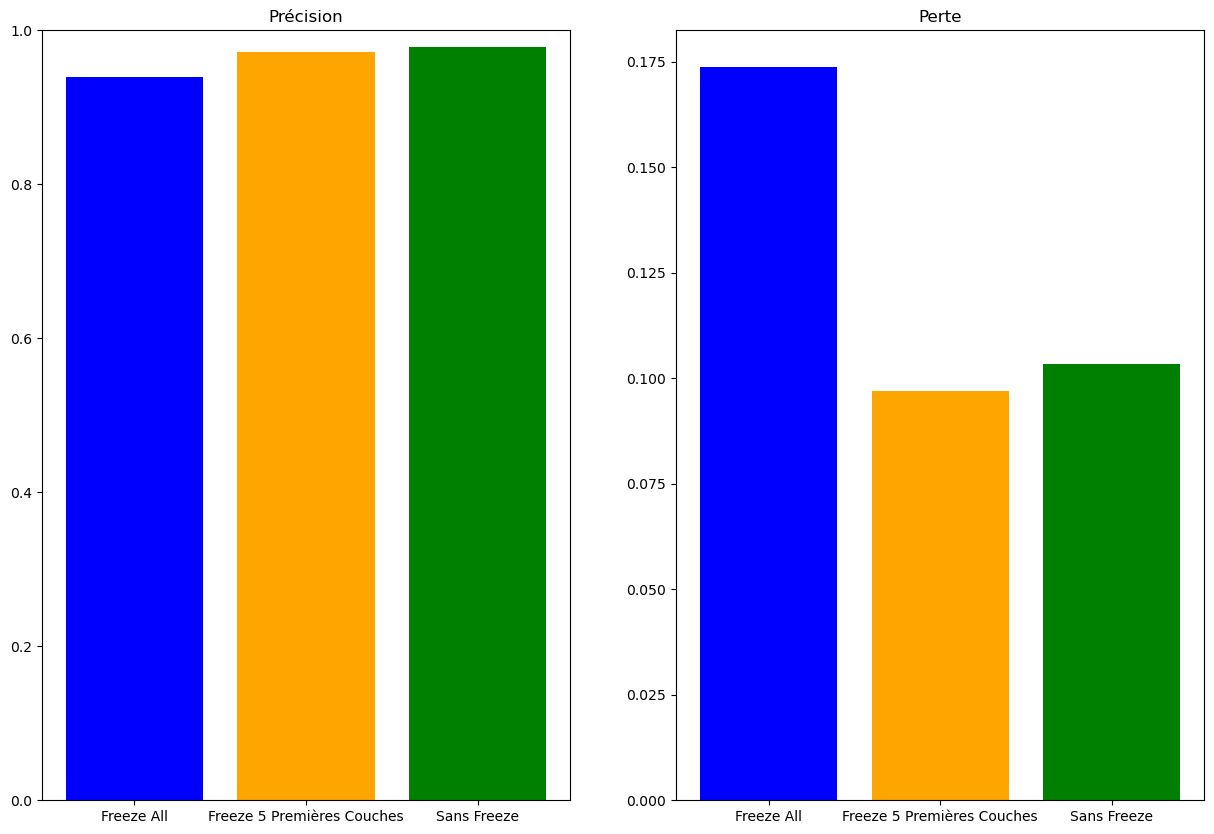

In [82]:
import matplotlib.pyplot as plt

# Récupérer les résultats
resultat_modelVGG16avecfreeze_ALL = {"loss": resultat_modelVGG16avecfreeze_ALL["loss"], "accuracy": resultat_modelVGG16avecfreeze_ALL["accuracy"]}
resultat_modelVGG16avecfreeze_cinq={"loss": resultat_modelVGG16avecfreeze_cinq["loss"], "accuracy": resultat_modelVGG16avecfreeze_cinq["accuracy"]}
resultat_modelVGG16_Withoutfreeze={"loss": resultat_modelVGG16_Withoutfreeze["loss"], "accuracy": resultat_modelVGG16_Withoutfreeze["accuracy"]}

# Créer une figure avec deux sous-graphiques
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 10))

# Tracer l'histogramme pour la précision
ax1.bar(["Freeze All", "Freeze 5 Premières Couches", "Sans Freeze"],
        [resultat_modelVGG16avecfreeze_ALL['accuracy'],
         resultat_modelVGG16avecfreeze_cinq['accuracy'],
         resultat_modelVGG16_Withoutfreeze['accuracy']],
        color=['blue', 'orange', 'green'])
ax1.set_title('Précision')
ax1.set_ylim([0, 1])

# Tracer l'histogramme pour la perte
ax2.bar(["Freeze All", "Freeze 5 Premières Couches", "Sans Freeze"],
        [resultat_modelVGG16avecfreeze_ALL['loss'],
         resultat_modelVGG16avecfreeze_cinq['loss'],
         resultat_modelVGG16_Withoutfreeze['loss']],
        color=['blue', 'orange', 'green'])
ax2.set_title('Perte')

# Afficher la figure
plt.show()

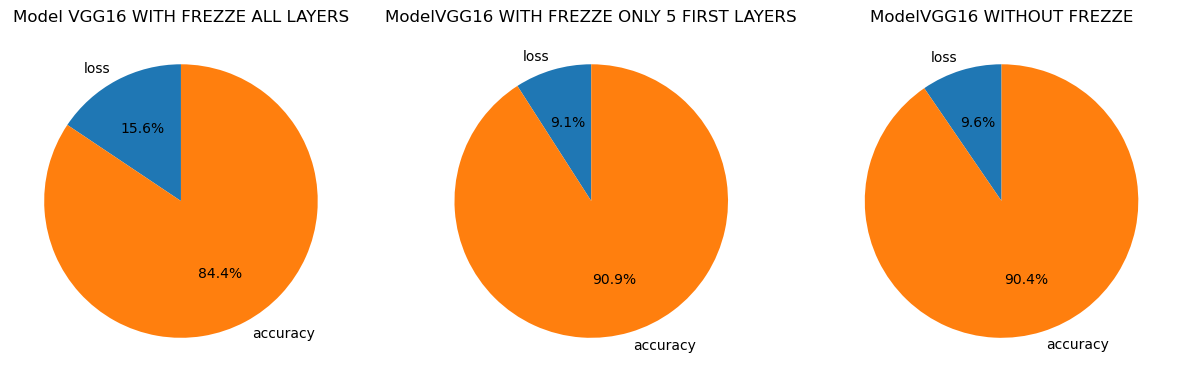

In [252]:
import matplotlib.pyplot as plt
resultat_modelVGG16avecfreeze_ALL = {"loss": resultat_modelVGG16avecfreeze_ALL["loss"], "accuracy": resultat_modelVGG16avecfreeze_ALL["accuracy"]}
resultat_modelVGG16avecfreeze_cinq={"loss": resultat_modelVGG16avecfreeze_cinq["loss"], "accuracy": resultat_modelVGG16avecfreeze_cinq["accuracy"]}
resultat_modelVGG16_Withoutfreeze={"loss": resultat_modelVGG16_Withoutfreeze["loss"], "accuracy": resultat_modelVGG16_Withoutfreeze["accuracy"]}

# Extracting values
labels = list(resultat_modelVGG16avecfreeze_ALL.keys())

values_VGG16avecfreeze_ALL = list(resultat_modelVGG16avecfreeze_ALL.values())
values_VGG16avecfreeze_cinq = list(resultat_modelVGG16avecfreeze_cinq.values())
values_VGG16_Withoutfreeze = list(resultat_modelVGG16_Withoutfreeze.values())

# Plotting pie charts
fig, axs = plt.subplots(1, 3, figsize=(15, 15))

# Pie chart for Model with Data Augmentation
k1=axs[0].pie(values_VGG16avecfreeze_ALL, labels=labels, autopct='%1.1f%%', startangle=90)
t1=axs[0].set_title('Model VGG16 WITH FREZZE ALL LAYERS')

# Pie chart for Model without Data Augmentation
k2=axs[1].pie(values_VGG16avecfreeze_cinq, labels=labels, autopct='%1.1f%%', startangle=90)
t2=axs[1].set_title('ModelVGG16 WITH FREZZE ONLY 5 FIRST LAYERS')

k3=axs[2].pie(values_VGG16_Withoutfreeze, labels=labels, autopct='%1.1f%%', startangle=90)
t3=axs[2].set_title('ModelVGG16 WITHOUT FREZZE')
plt.show()

**COMMENTS**

In [253]:
text_representation = str(k1[-1][-1])
t1=str(t1).split("'")[-2]

val1_accuracy= text_representation.split("'")[-2]
print("Accuracy de ",t1," est ",val1_accuracy)

text_representation = str(k2[-1][-1])
val2_accuracy = text_representation.split("'")[-2]
t2=str(t2).split("'")[-2]
print("Accuracy de ",t2," est ", val2_accuracy)

text_representation = str(k3[-1][-1])
val3_accuracy = text_representation.split("'")[-2]
t3=str(t3).split("'")[-2]
print("Accuracy de ",t3," est ", val3_accuracy)

print("\n\nBest Model : ")
max_accuracy = max(val1_accuracy, val2_accuracy, val3_accuracy)
# Attribution du nom correspondant à la valeur maximale
if max_accuracy == val1_accuracy:
    best_model_VGG16={t1:val1_accuracy,"model":resultat_modelVGG16avecfreeze_ALL}
    print("Accuracy de best model est le model ",t1," est ",val1_accuracy)
elif max_accuracy == val2_accuracy:
    best_model_VGG16={t2:val2_accuracy,"model":resultat_modelVGG16avecfreeze_cinq}
    print("Accuracy de best model est le model ",t2," est ",val2_accuracy)
else:
    best_model_VGG16={t3:val3_accuracy,"model":resultat_modelVGG16_Withoutfreeze}
    print("Accuracy de best model est le model ",t3," est ",val3_accuracy)



Accuracy de  Model VGG16 WITH FREZZE ALL LAYERS  est  84.4%
Accuracy de  ModelVGG16 WITH FREZZE ONLY 5 FIRST LAYERS  est  90.9%
Accuracy de  ModelVGG16 WITHOUT FREZZE  est  90.4%


Best Model : 
Accuracy de best model est le model  ModelVGG16 WITH FREZZE ONLY 5 FIRST LAYERS  est  90.9%


**PART 5_3 :COMPARAISON ENTRE MODELE VGG19  without including Fully connected Layer / WITH including Fully connected Layer**

**5_3_1)ENTRAINEMENT DU MODELE VGG19 WITHOUT INCLUDING FULLY CONNECTED LAYER**

In [13]:
modelVGG19False=Creation_modelVGG19False()
historyModelVGG19False,validation_generatorVGG19False=Main_Model(modelVGG19False,
                                      parmas['batch_size'],
                                      parmas['loss'],
                                      parmas['optimizer'],
                                      "EBestModel_VGG19False.h5",
                                      parmas['patience'],
                                      parmas['nbrepochs'],
                                      "withdataAugementation"
                                      )

Found 5944 images belonging to 2 classes.
Found 3060 images belonging to 2 classes.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_27896\464600863.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  return model.fit_generator(


Epoch 1/30
60/60 [==============================] - ETA: 0s - loss: 0.2789 - accuracy: 0.8954
Epoch 1: val_accuracy improved from -inf to 0.95425, saving model to EBestModel_VGG19False.h5
60/60 [==============================] - 181s 3s/step - loss: 0.2789 - accuracy: 0.8954 - val_loss: 0.1273 - val_accuracy: 0.9542
Epoch 2/30
60/60 [==============================] - ETA: 0s - loss: 0.1273 - accuracy: 0.9601
Epoch 2: val_accuracy improved from 0.95425 to 0.96242, saving model to EBestModel_VGG19False.h5
60/60 [==============================] - 183s 3s/step - loss: 0.1273 - accuracy: 0.9601 - val_loss: 0.1160 - val_accuracy: 0.9624
Epoch 3/30
60/60 [==============================] - ETA: 0s - loss: 0.0965 - accuracy: 0.9712
Epoch 3: val_accuracy improved from 0.96242 to 0.96797, saving model to EBestModel_VGG19False.h5
60/60 [==============================] - 179s 3s/step - loss: 0.0965 - accuracy: 0.9712 - val_loss: 0.1024 - val_accuracy: 0.9680
Epoch 4/30
60/60 [======================

**5_3_2)ENTRAINEMENT DU MODELE VGG19 WITH INCLUDING FULLY CONNECTED LAYER**

In [ ]:
modelVGG19True=Creation_modelVGG19True()
historyVGG19True,validation_generatorVGG19True=Main_Model(modelVGG19True,
                                      parmas['batch_size'],
                                      parmas['loss'],
                                      parmas['optimizer'],
                                      "BestModel_VGG19True.h5",
                                      parmas['patience'],
                                      parmas['nbrepochs'],
                                     "withdataAugementation"
                                      )

**5_3_3) EVALUTION MODELES**

In [13]:
resultat_modelVGG19False=evaluerModel( "EBestModel_VGG19False.h5",validation_generatorCNNWithoutDataAugmentaion)
resultat_modelVGG19True=evaluerModel( "BestModel_VGG19True.h5",validation_generatorCNNWithoutDataAugmentaion)



C:\Users\Lenovo\AppData\Local\Temp\ipykernel_12924\4089831305.py:3: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  loss, accuracy = model.evaluate_generator(validation_gen, verbose=1)


31/31 [==============================] - 326s 11s/step - loss: 0.1132 - accuracy: 0.9647


***5_3_4)COMPARER***

In [ ]:
print("\n\nRESULTAT DU MODELE VGG19 WITHOUT INCLUDING FULLY CONNECTED LAYER")
print(resultat_modelVGG19False)
print("\n\nRESULTAT DU MODELE VGG19 WITH INCLUDING FULLY CONNECTED LAYER")
print(resultat_modelVGG19True)


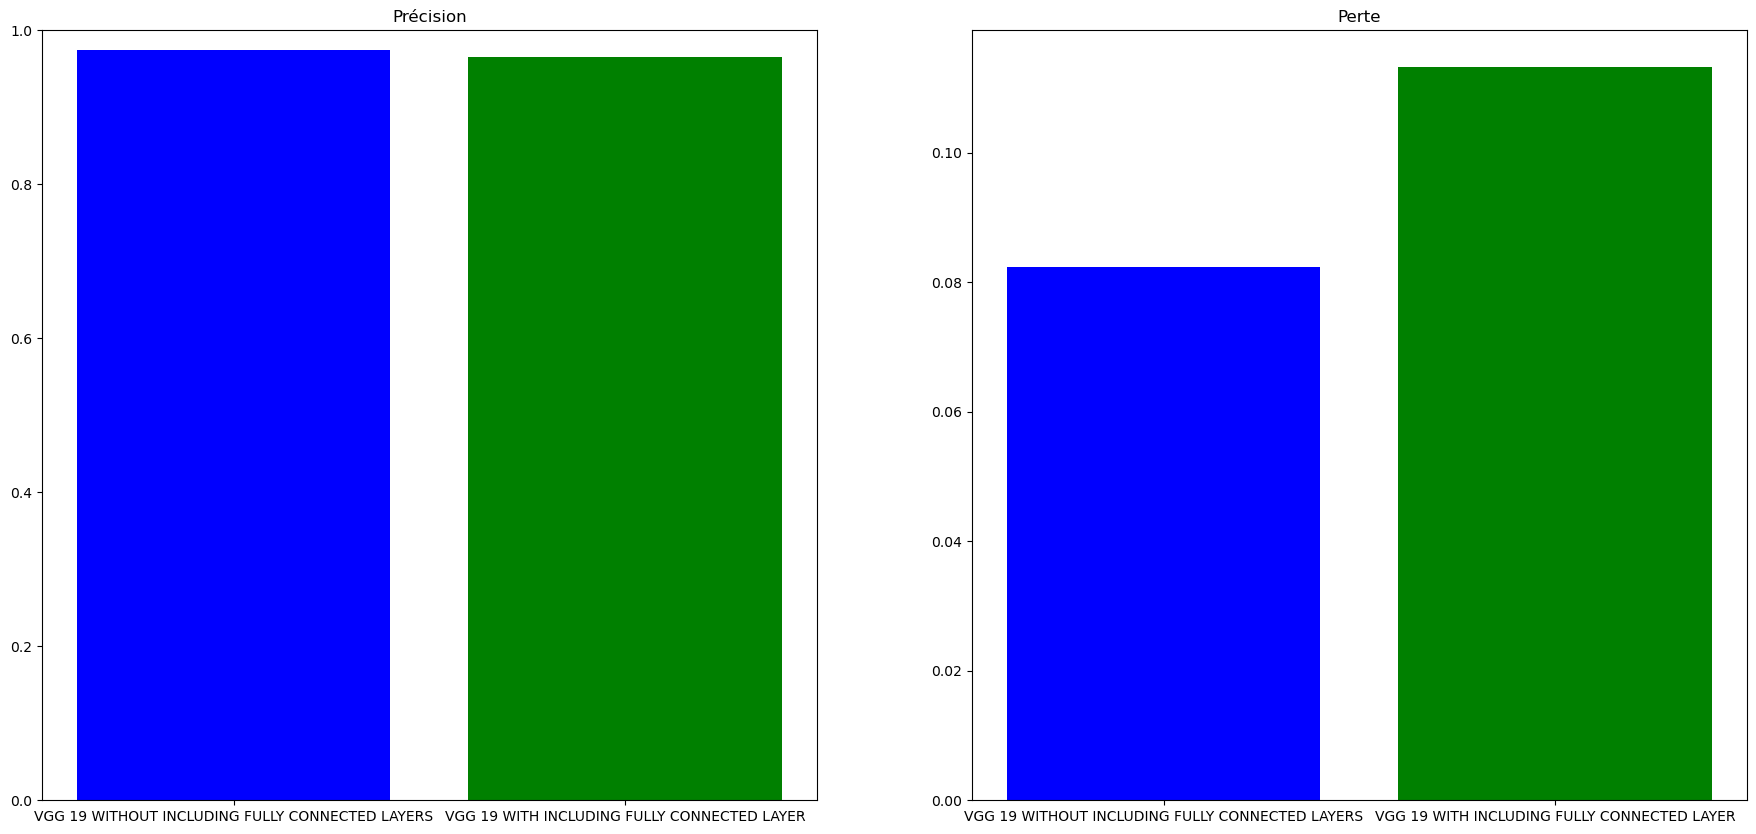

In [85]:
import matplotlib.pyplot as plt

# Récupérer les résultats
resultat_modelVGG19False = {"loss": resultat_modelVGG19False["loss"], "accuracy": resultat_modelVGG19False["accuracy"]}
resultat_modelVGG19True={"loss": resultat_modelVGG19True["loss"], "accuracy": resultat_modelVGG19True["accuracy"]}

# Créer une figure avec deux sous-graphiques
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(22, 10))

# Tracer l'histogramme pour la précision
ax1.bar(["VGG 19 WITHOUT INCLUDING FULLY CONNECTED LAYERS", "VGG 19 WITH INCLUDING FULLY CONNECTED LAYER"],
        [resultat_modelVGG19False['accuracy'],
         resultat_modelVGG19True['accuracy']],
        color=['blue', 'green'])
ax1.set_title('Précision')
ax1.set_ylim([0, 1])

# Tracer l'histogramme pour la perte
ax2.bar(["VGG 19 WITHOUT INCLUDING FULLY CONNECTED LAYERS", "VGG 19 WITH INCLUDING FULLY CONNECTED LAYER"],
        [resultat_modelVGG19False['loss'],
         resultat_modelVGG19True['loss']
       ],
        color=['blue', 'green'])
ax2.set_title('Perte')

# Afficher la figure
plt.show()

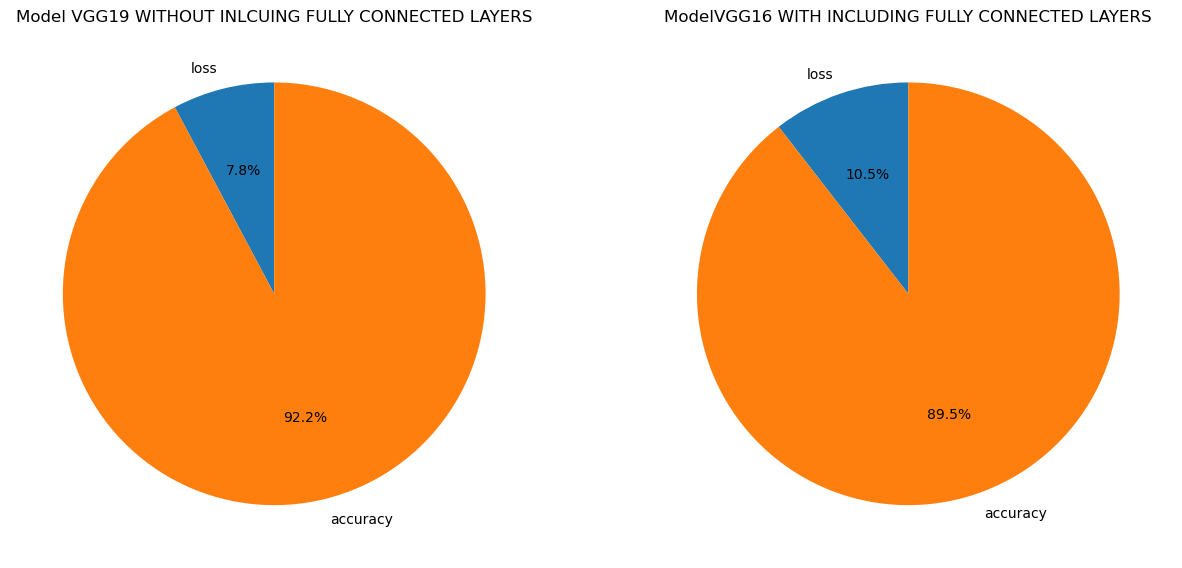

In [249]:
import matplotlib.pyplot as plt
resultat_modelVGG19False = {"loss": resultat_modelVGG19False["loss"], "accuracy": resultat_modelVGG19False["accuracy"]}
resultat_modelVGG19True={"loss": resultat_modelVGG19True["loss"], "accuracy": resultat_modelVGG19True["accuracy"]}

# Extracting values
labels = list(resultat_modelVGG19False.keys())

values_modelVGG19False = list(resultat_modelVGG19False.values())
values_modelVGG19True = list(resultat_modelVGG19True.values())

# Plotting pie charts
fig, axs = plt.subplots(1,2, figsize=(15, 15))

# Pie chart for Model with Data Augmentation
k1=axs[0].pie(values_modelVGG19False, labels=labels, autopct='%1.1f%%', startangle=90)
t1=axs[0].set_title('Model VGG19 WITHOUT INLCUING FULLY CONNECTED LAYERS')

# Pie chart for Model without Data Augmentation
k2=axs[1].pie(values_modelVGG19True, labels=labels, autopct='%1.1f%%', startangle=90)
t2=axs[1].set_title('ModelVGG16 WITH INCLUDING FULLY CONNECTED LAYERS')


plt.show()

In [250]:
text_representation = str(k1[-1][-1])
t1=str(t1).split("'")[-2]

val1_accuracy = text_representation.split("'")[-2]
print("Accuracy de ",t1," est ",val1_accuracy )

text_representation = str(k2[-1][-1])
t2=str(t2).split("'")[-2]

val2_accuracy = text_representation.split("'")[-2]
print("Accuracy de ",t2," est ",val2_accuracy )


print("\n\nBest Model : ")
if(val1_accuracy>val2_accuracy):
    best_model_VGG19={t1:val1_accuracy,"model":resultat_modelVGG19False}
    print("Accuracy de best model est le model",t1," est ",val1_accuracy)
else:
    best_model_VGG19={t2:val2_accuracy,"model":resultat_modelVGG19True}
    print("Accuracy de best model est le model ",t2," est ",val2_accuracy)


Accuracy de  Model VGG19 WITHOUT INLCUING FULLY CONNECTED LAYERS  est  92.2%
Accuracy de  ModelVGG16 WITH INCLUDING FULLY CONNECTED LAYERS  est  89.5%


Best Model : 
Accuracy de best model est le model Model VGG19 WITHOUT INLCUING FULLY CONNECTED LAYERS  est  92.2%


**PART 6: COMPARAISON ENTRE LES 3 MODELES CNN FROM SCRTCH , VGG 16 ET VGG 19**


In [251]:
print(best_model_VGG19 )
print(best_model_CNN_FROM_SCRATCH)
print(best_model_VGG16)
maxAccuracy=max(list(best_model_VGG19.values())[0]
,list(best_model_CNN_FROM_SCRATCH.values())[0]
,list(best_model_VGG16.values())[0]
)
print("\n\nBEST MODELE \n\n")
if maxAccuracy == list(best_model_VGG19.values())[0]:
    best_model=load_model("BestModel_VGG19True.h5")
    print("Le best model est le",list(best_model_VGG19.keys())[0]," avec ",maxAccuracy," accuracy")
elif maxAccuracy == list(best_model_CNN_FROM_SCRATCH.values())[0]:
    best_model=load_model("BestModelCNN_FromScratchWITHDataAugmentation.h5")
    print("Le best model est le",list(best_model_CNN_FROM_SCRATCH.keys())[0]," avec ",maxAccuracy," accuracy")
else:
    best_model=load_model("BestModel_Vgg16Freeze_cinq.h5")
    print("Le best model est le",list(best_model_VGG16.keys())[0]," avec ",maxAccuracy," accuracy")

{'Model VGG19 WITHOUT INLCUING FULLY CONNECTED LAYERS': '92.2%', 'model': {'loss': 0.08227183669805527, 'accuracy': 0.9738562107086182}}
{'Model CNN FROM SCRATCH with Data Augmentation': '86.2%'}
{'ModelVGG16 WITH FREZZE ONLY 5 FIRST LAYERS': '90.9%'}


BEST MODELE 


Le best model est le Model VGG19 WITHOUT INLCUING FULLY CONNECTED LAYERS  avec  92.2%  accuracy


**PREDICTED DU BEST MODELE**

In [264]:
def predict(model, img):
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    preds = model.predict(x)
    return preds[0]

In [265]:
def CalculAccuracyDuClass(model,nomFichier,img_path,indexClass):
    vrai=0
    totale=0
    text_file1 =open(nomFichier,"w")
    img_path=img_path
    for id,img_name in enumerate(sorted(os.listdir(img_path))):
        if not img_name.lower().endswith(("bmp","peg","jpg","png","tif","tiff")):
            continue
        print(img_name)
        filepath = os.path.join(img_path,img_name)
        img = load_img(filepath, target_size=(224, 224))
        totale += 1
        preds = predict(model,img)
        if preds[indexClass]>=0.5:
            vrai+=1
        else:
            text_file1.write(filepath +"\n")
        print(preds)
    acc1=(vrai/totale)*100
    return acc1

In [266]:
acc1=CalculAccuracyDuClass(best_model,"falseDetectedface.txt","moheddine/test224/face",0)
acc2=CalculAccuracyDuClass(best_model,"falseDetectedMaskface.txt","moheddine/test224/maskface",1)

013_Interview_Interview_2_People_Visible_13_107.jpg
1/1 [==============================] - 0s 172ms/step
[0.99573237 0.00426765]
013_Interview_Interview_2_People_Visible_13_155.jpg
1/1 [==============================] - 0s 154ms/step
[9.9970055e-01 2.9945327e-04]
013_Interview_Interview_2_People_Visible_13_189.jpg
1/1 [==============================] - 0s 141ms/step
[0.9951746  0.00482545]
013_Interview_Interview_2_People_Visible_13_204.jpg
1/1 [==============================] - 0s 129ms/step
[9.9967551e-01 3.2453856e-04]
013_Interview_Interview_2_People_Visible_13_217.jpg
1/1 [==============================] - 0s 134ms/step
[9.9968016e-01 3.1990735e-04]
013_Interview_Interview_2_People_Visible_13_237.jpg
1/1 [==============================] - 0s 134ms/step
[9.99882817e-01 1.17182644e-04]
013_Interview_Interview_2_People_Visible_13_239.jpg
1/1 [==============================] - 0s 134ms/step
[9.9976140e-01 2.3864386e-04]
013_Interview_Interview_2_People_Visible_13_241.jpg
1/1 [========

**ACCURACY FINAL DU BEST MODEL**

In [273]:
print("accuracy de detection du face :", acc1)
print("accuracy de detection du maskface :" ,acc2)


print("\n\n Accuracy du model final : ", (acc1+acc2)/2,"%")

accuracy de detection du face : 97.52352649826646
accuracy de detection du maskface : 93.75600384245918


 Accuracy du model final :  95.63976517036282 %


**FALSE DETECTION FACE**

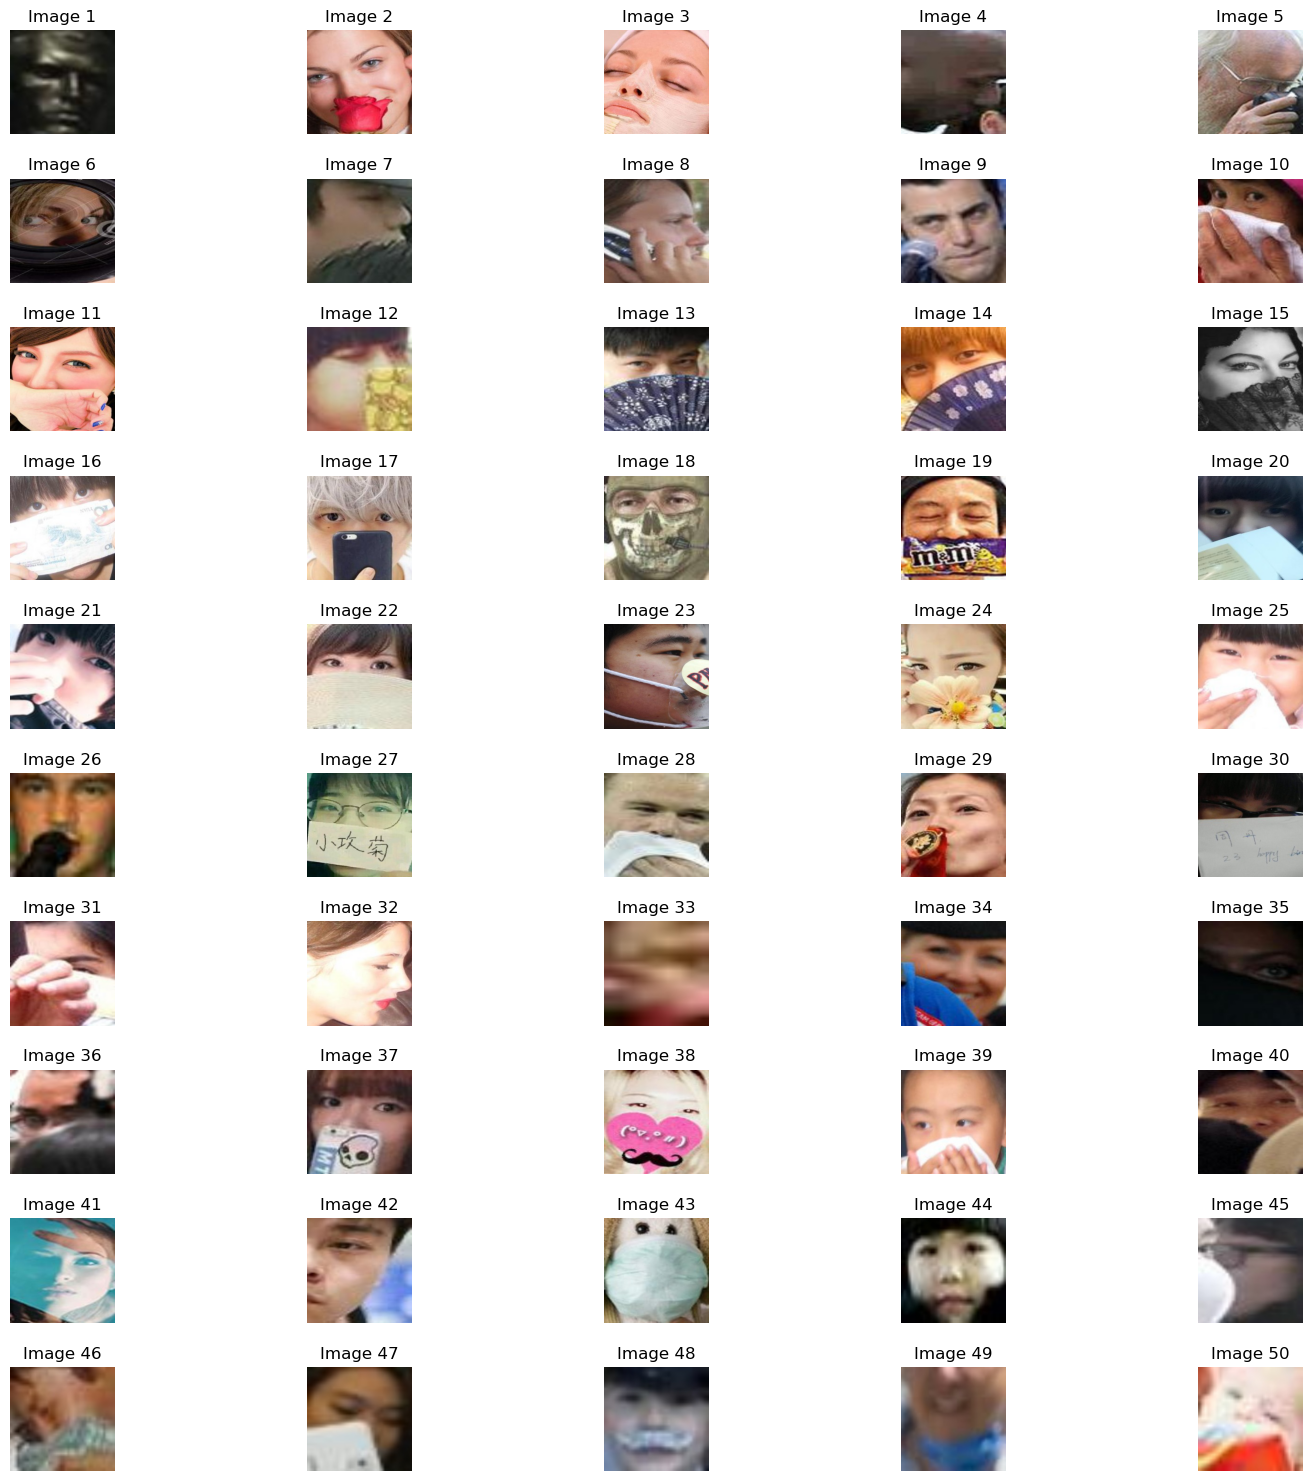

In [301]:
import matplotlib.pyplot as plt
from PIL import Image

with open("falseDetectedface.txt", "r") as text_file1:
    images = []
    for line in text_file1:
        image_path = line.strip()
        try:
            img = Image.open(image_path)
            images.append(img)
        except Exception as e:
            print(f"Erreur lors du chargement de l'image {image_path}: {e}")

num_columns = 5
num_rows = (len(images) + num_columns - 1) // num_columns
fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, 15))
fig.tight_layout()
for i, img in enumerate(images):
    row = i // num_columns
    col = i % num_columns
    axes[row, col].imshow(img)
    axes[row, col].set_title(f"Image {i+1}")
    axes[row, col].axis("off")  

plt.show()


**FALSE DETECTION MASK FACE**

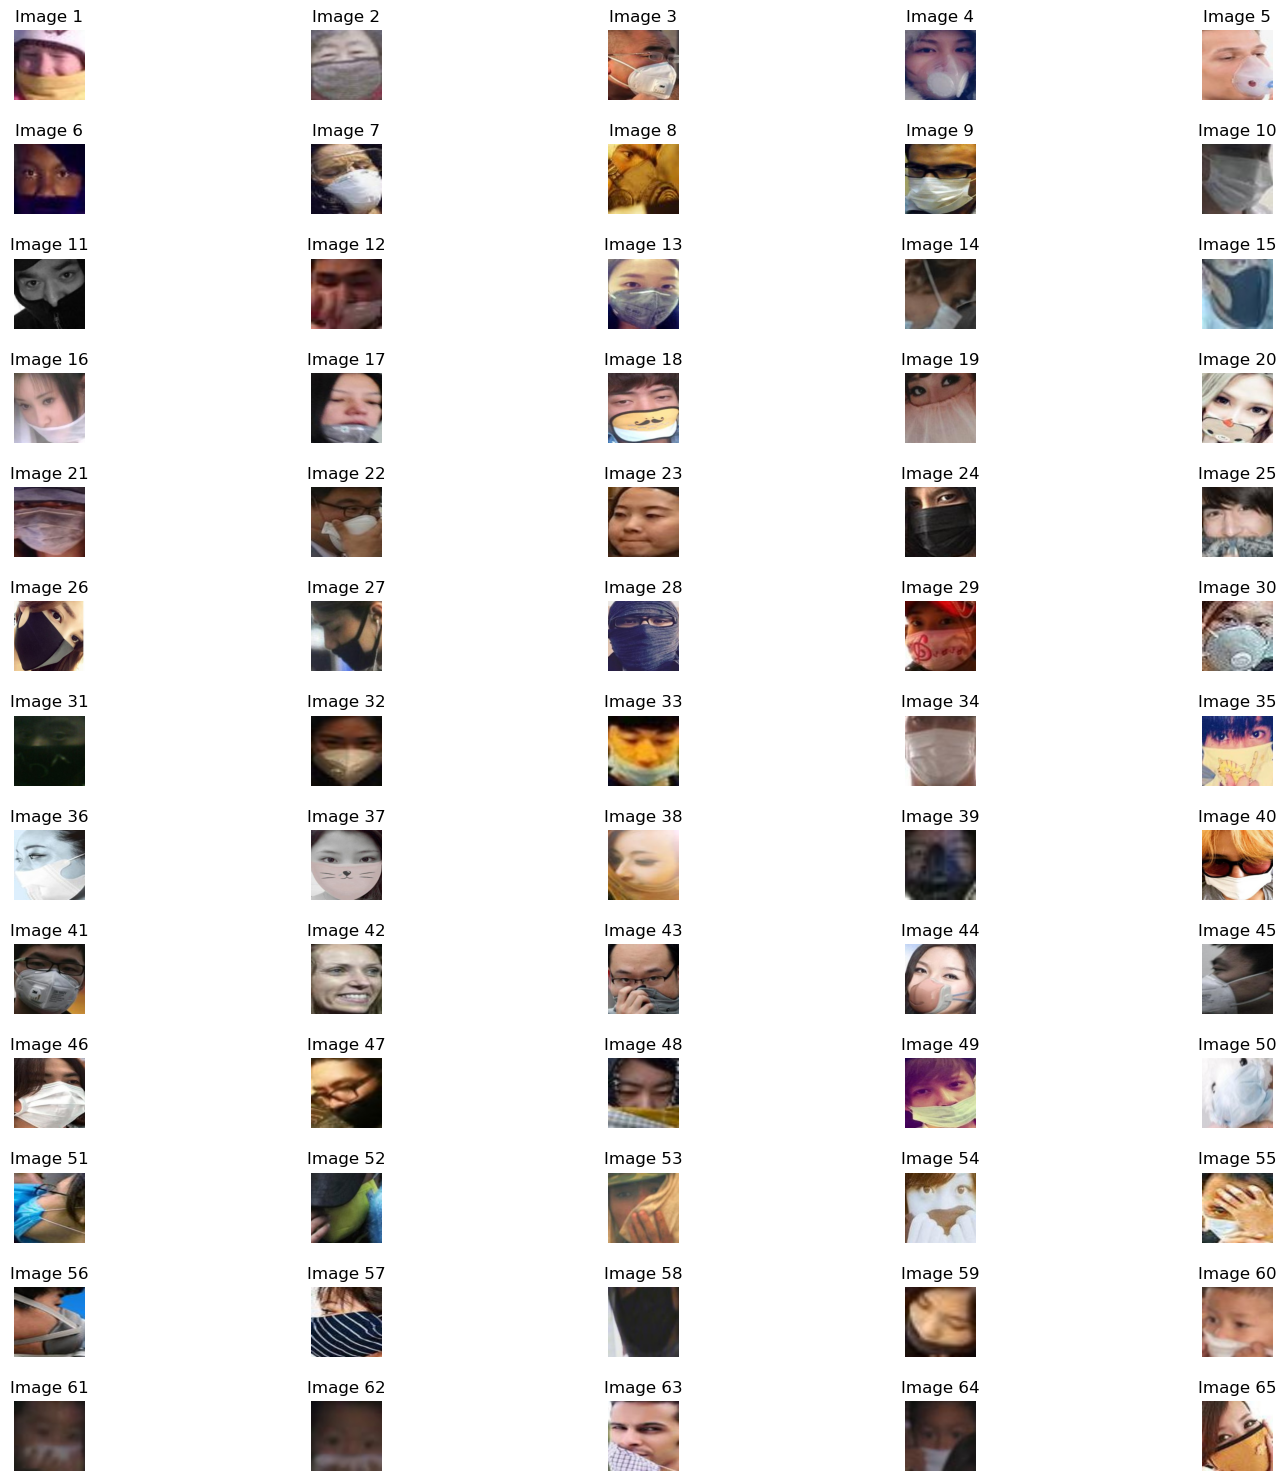

In [302]:
import matplotlib.pyplot as plt
from PIL import Image

with open("falseDetectedMaskface.txt", "r") as text_file1:
    images = []
    for line in text_file1:
        image_path = line.strip()
        try:
            img = Image.open(image_path)
            images.append(img)
        except Exception as e:
            print(f"Erreur lors du chargement de l'image {image_path}: {e}")

num_columns = 5
num_rows = (len(images) + num_columns - 1) // num_columns
fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, 15))
fig.tight_layout()
for i, img in enumerate(images):
    row = i // num_columns
    col = i % num_columns
    axes[row, col].imshow(img)
    axes[row, col].set_title(f"Image {i+1}")
    axes[row, col].axis("off") 

plt.show()
